In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
import math

%matplotlib inline

In [2]:
font = {'size': 13.0}

plt.rc('font', **font)
plt.rcParams['axes.formatter.useoffset'] = False

In [3]:
copper_shapes = pd.read_csv('./data/values/copper').to_numpy()
iron_shapes = pd.read_csv('./data/values/iron').to_numpy()
ironthick_shapes = pd.read_csv('./data/values/ironthick').to_numpy()
distances = pd.read_csv('./data/values/distances', header=None).to_numpy().reshape((-1,))[:-1]

In [4]:
print(distances)

[0.04 0.36 0.68 1.32 1.96 2.6  3.24 3.88 4.52 5.16 5.8 ]


In [5]:
# frequencies with no metal object
empty = pd.read_csv('data/freq_and_volt/empty1/frequency', header=None).to_numpy() / 1e3
empty_std = empty.std()

In [6]:
copper_shape_fs = []
copper_shape_vs = []
iron_shape_fs = []
iron_shape_vs = []

for i in range(2,12):
    copper_shape_fs.append(pd.read_csv(f'./data/freq_and_volt/coppershape{i}/frequency', header=None).to_numpy().reshape((-1,)))
    copper_shape_vs.append(pd.read_csv(f'./data/freq_and_volt/coppershape{i}/peak2peak', header=None).to_numpy().reshape((-1,)) / 2)
    
    iron_shape_fs.append(pd.read_csv(f'./data/freq_and_volt/ironshape{i}/frequency', header=None).to_numpy().reshape((-1,)))
    iron_shape_vs.append(pd.read_csv(f'./data/freq_and_volt/ironshape{i}/peak2peak', header=None).to_numpy().reshape((-1,)) / 2)

copper_shape_fs = np.array(copper_shape_fs)
copper_shape_vs = np.array(copper_shape_vs)
iron_shape_fs = np.array(iron_shape_fs)
iron_shape_vs = np.array(iron_shape_vs)

In [7]:
ironthick_shape_freq = pd.read_csv('./data/freq_and_volt/ironthickshape1/frequency', header=None).to_numpy().reshape((-1,))
ironthick_shape_volt = pd.read_csv('./data/freq_and_volt/ironthickshape1/peak2peak', header=None).to_numpy().reshape((-1,)) / 2

In [8]:
# Distance data was collected with 3x3cm copper sheet
distance_fs = []
distance_vs = []

for i in range(2, 12):
    distance_fs.append(pd.read_csv(f'./data/freq_and_volt/distance{i}/frequency', header=None).to_numpy().reshape((-1,)))
    distance_vs.append(pd.read_csv(f'./data/freq_and_volt/distance{i}/peak2peak', header=None).to_numpy().reshape((-1,)) / 2)

distance_fs = np.array(distance_fs)
distance_vs = np.array(distance_vs)

distance_fs.shape

(10, 22)

In [9]:
# material comp data
# copper and iron size: 3x3x0.1cm
# silver size: 2.5x3.5x0.08cm
# brass size: 3x3x0.08cm
material_labels = ['3x3x0.1cm\n$\\bf{Copper}$\n$\\it\\rho: 1.68x10^{-8} \Omega m}$',
                   '3x3x0.1cm\n$\\bf{Iron}$\n$\\it{\\rho: 9.70x10^{-8} \Omega m}$',
                   '2.5x3.5x0.08cm\n$\\bf{Silver}$\n$\\it{\\rho: 1.59x10^{-8} \Omega m}$',
                   '3x3x0.08cm\n$\\bf{Brass}$\n$\\it{\\rho: 6-9 x10^{-8} \Omega m}$']
material_fs = []
material_vs = []

for i in range(1,11):
    material_fs.append(pd.read_csv(f'./data/freq_and_volt/materialcomp{i}/frequency', header=None).to_numpy().reshape((-1,)))
    material_vs.append(pd.read_csv(f'./data/freq_and_volt/materialcomp{i}/peak2peak', header=None).to_numpy().reshape((-1,)) / 2)

material_fs = np.array(material_fs)
material_vs = np.array(material_vs)

In [10]:
# iron thickness comp data
# thin: 3x3x0.1cm
# thick: 3x3x0.15cm
ironthickcomp_labels = ['0.1cm', '0.15cm']
ironthickcomp_fs = []
ironthickcomp_vs = []

for i in range(1, 11):
    ironthickcomp_fs.append(pd.read_csv(f'./data/freq_and_volt/ironthickcomp{i}/frequency', header=None).to_numpy().reshape((-1,)))
    ironthickcomp_vs.append(pd.read_csv(f'./data/freq_and_volt/ironthickcomp{i}/peak2peak', header=None).to_numpy().reshape((-1,)) / 2)
    
ironthickcomp_fs = np.array(ironthickcomp_fs)
ironthickcomp_vs = np.array(ironthickcomp_vs)

## Convert to difference arrays

In [11]:
copper_shape_freq_diff = (copper_shape_fs[:,1:] - copper_shape_fs[:,0].reshape((-1,1))) / 1e3
iron_shape_freq_diff = (iron_shape_fs[:,1:] - iron_shape_fs[:,0].reshape((-1,1))) / 1e3
ironthick_shape_freq_diff = (ironthick_shape_freq[1:] - ironthick_shape_freq[0]) / 1e3

copper_shape_volt_diff = copper_shape_vs[:,1:] - copper_shape_vs[:,0].reshape((-1,1))
iron_shape_volt_diff = iron_shape_vs[:,1:] - iron_shape_vs[:,0].reshape((-1,1))
ironthick_shape_volt_diff = ironthick_shape_volt[1:] - ironthick_shape_volt[0]

In [12]:
# for distance values a reference element is in front of every measurement

distance_freq_diff = np.zeros((distance_fs.shape[0], int(distance_fs.shape[1]/2)))
distance_volt_diff = np.zeros((distance_vs.shape[0], int(distance_vs.shape[1]/2)))
for i in range(int(distance_fs.shape[1]/2)):
    for j in  range(distance_fs.shape[0]):
        distance_freq_diff[j][i] = (distance_fs[j][i*2+1] - distance_fs[j][i*2]) / 1e3
        distance_volt_diff[j][i] = distance_vs[j][i*2+1] - distance_vs[j][i*2]
        
        
print(distance_freq_diff.shape)
distance_freq_diff

(10, 11)


array([[45.58402193, 27.47801679, 16.85690999,  6.60135303,  2.83662464,
         1.26428288,  0.61436209,  0.31506931,  0.20258421,  0.10037847,
         0.05468768],
       [46.15503232, 27.94813011, 17.11629377,  6.4543892 ,  2.85401311,
         1.30671119,  0.65701928,  0.34050964,  0.17518506,  0.08611501,
         0.06730158],
       [45.21867456, 28.26446339, 17.17617957,  6.7472409 ,  2.84795756,
         1.29078355,  0.63627794,  0.3351023 ,  0.18877562,  0.11475371,
         0.0545301 ],
       [47.20770998, 28.3428303 , 17.60063899,  6.81165772,  2.90494623,
         1.30981226,  0.63936981,  0.33248107,  0.17356169,  0.08628194,
         0.05917221],
       [46.8666765 , 28.46034778, 17.46960709,  6.83972717,  2.88664208,
         1.32564284,  0.63376114,  0.33511506,  0.18070465,  0.10364194,
         0.06310142],
       [45.98160643, 28.66924768, 17.31673464,  6.70228091,  2.83965237,
         1.31374532,  0.62905157,  0.33958992,  0.18518805,  0.10407556,
         0.064

In [13]:
# material comp
material_freq_diff = np.zeros((material_fs.shape[0], int(material_fs.shape[1]/2)))
material_volt_diff = np.zeros((material_vs.shape[0], int(material_vs.shape[1]/2)))
for i in range(int(material_fs.shape[1]/2)):
    for j in  range(material_fs.shape[0]):
        material_freq_diff[j][i] = (material_fs[j][i*2+1] - material_fs[j][i*2]) / 1e3
        material_volt_diff[j][i] = material_vs[j][i*2+1] - material_vs[j][i*2]
    
material_freq_means = np.mean(material_freq_diff, axis=0)
material_freq_stds = np.std(material_freq_diff, axis=0)

material_volt_means = np.mean(material_volt_diff, axis=0)
material_volt_stds = np.std(material_volt_diff, axis=0)

In [14]:
# ironthick comp
ironthickcomp_freq_diff = np.zeros((ironthickcomp_fs.shape[0], int(ironthickcomp_fs.shape[1]/2)))
ironthickcomp_volt_diff = np.zeros((ironthickcomp_vs.shape[0], int(ironthickcomp_vs.shape[1]/2)))
for i in range(int(ironthickcomp_fs.shape[1]/2)):
    for j in  range(ironthickcomp_fs.shape[0]):
        ironthickcomp_freq_diff[j][i] = (ironthickcomp_fs[j][i*2+1] - ironthickcomp_fs[j][i*2]) / 1e3
        ironthickcomp_volt_diff[j][i] = ironthickcomp_vs[j][i*2+1] - ironthickcomp_vs[j][i*2]
        
ironthickcomp_freq_means = np.mean(ironthickcomp_freq_diff, axis=0)
ironthickcomp_freq_stds = np.std(ironthickcomp_freq_diff, axis=0)

ironthickcomp_volt_means = np.mean(ironthickcomp_volt_diff, axis=0)
ironthickcomp_volt_stds = np.std(ironthickcomp_volt_diff, axis=0)

## Calculate surface values

In [15]:
copper_surface = copper_shapes[:,0]*copper_shapes[:,1]
iron_surface = iron_shapes[:,0]*iron_shapes[:,1]
ironthick_surface = ironthick_shapes[:,0]*ironthick_shapes[:,1]

In [16]:
copper_shape_freq_means = np.mean(copper_shape_freq_diff, axis=0)
copper_shape_freq_stds = np.std(copper_shape_freq_diff, axis=0)
copper_shape_volt_means = np.mean(copper_shape_volt_diff, axis=0)
copper_shape_volt_stds = np.std(copper_shape_volt_diff, axis=0)

iron_shape_freq_means = np.mean(iron_shape_freq_diff, axis=0)
iron_shape_freq_stds = np.std(iron_shape_freq_diff, axis=0)
iron_shape_volt_means = np.mean(iron_shape_volt_diff, axis=0)
iron_shape_volt_stds = np.std(iron_shape_volt_diff, axis=0)

distance_freq_means = np.mean(distance_freq_diff, axis=0)
distance_freq_stds = np.std(distance_freq_diff, axis=0)
distance_volt_means = np.mean(distance_volt_diff, axis=0)
distance_volt_stds = np.std(distance_volt_diff, axis=0)

## Plotting constants

In [17]:
freq_color = 'tab:blue'
volt_color = 'tab:red'

## Plot shape data

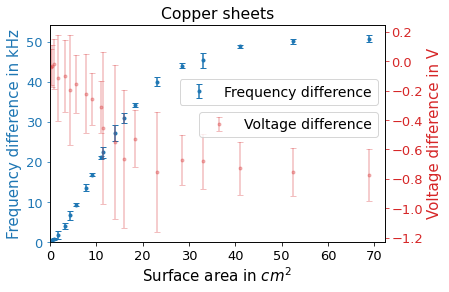

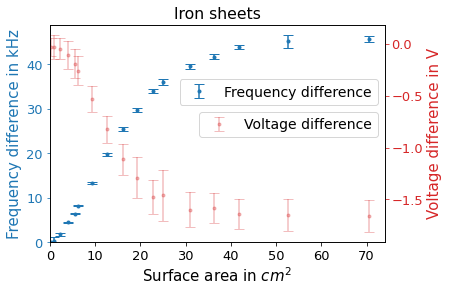

In [18]:
# All data is collected at a distance of 0.65cm

fig, ax1 = plt.subplots()
ax1.errorbar(copper_surface, copper_shape_freq_means, fmt='o', color=freq_color, capsize=3, markersize=3, yerr=copper_shape_freq_stds, label='Frequency difference', zorder=10)
#ax1.plot(iron_surface, iron_shape_freq_diff, 'x', label='Iron')
#ax1.plot(ironthick_surface, ironthick_shape_freq_diff, 'x', label='thick iron')
plt.title("Copper sheets")
plt.xlabel(r"Surface area in $cm^2$", fontsize=15)

ax1.set_ylabel("Frequency difference in kHz", color=freq_color, fontsize=15)

ax2 = ax1.twinx()
ax2.errorbar(copper_surface, copper_shape_volt_means, fmt='o', color=volt_color, capsize=3, markersize=3, yerr=copper_shape_volt_stds, label='Voltage difference', alpha=0.3, zorder=1)
ax2.set_ylabel('Voltage difference in V', color=volt_color, fontsize=15)
ax1.legend(loc="lower right", bbox_to_anchor=(1,0.6), fontsize=14)
ax2.legend(loc="lower right", bbox_to_anchor=(1,0.45), fontsize=14)

#ax1.axhline(y=0, color='black')
#ax2.axvline(x=0, color='black')
ax1.tick_params(axis='y', colors=freq_color)
ax2.tick_params(axis='y', colors=volt_color)
ax1.set_xlim(0)
ax1.set_ylim(0)

# Iron
fig, ax1 = plt.subplots()
ax1.errorbar(iron_surface, iron_shape_freq_means, fmt='o', color=freq_color, capsize=5, markersize=3, yerr=iron_shape_freq_stds, label='Frequency difference')
plt.title("Iron sheets")
plt.xlabel(r"Surface area in $cm^2$", fontsize=15)
ax1.set_ylabel("Frequency difference in kHz", color=freq_color, fontsize=15)

ax2 = ax1.twinx()
ax2.errorbar(iron_surface, iron_shape_volt_means, fmt='o', color=volt_color, capsize=5, markersize=3, yerr=iron_shape_volt_stds, label='Voltage difference', alpha=0.3)

ax2.set_ylabel('Voltage difference in V', color=volt_color, fontsize=15)
l1 = ax1.legend(loc="lower right", bbox_to_anchor=(1,0.6), fontsize=14)
l2 = ax2.legend(loc="lower right", bbox_to_anchor=(1,0.45), fontsize=14)
l1.set_zorder(20)
l2.set_zorder(30)

#ax1.axhline(y=0, color='black')
#ax2.axvline(x=0, color='black')

ax1.tick_params(axis='y', colors=freq_color)
ax2.tick_params(axis='y', colors=volt_color)
ax1.set_xlim(0)
ax1.set_ylim(0)
plt.show()

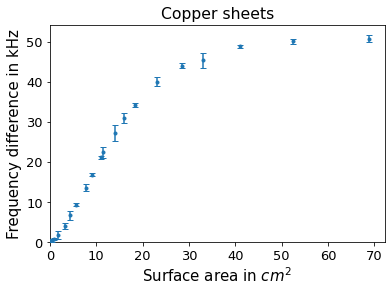

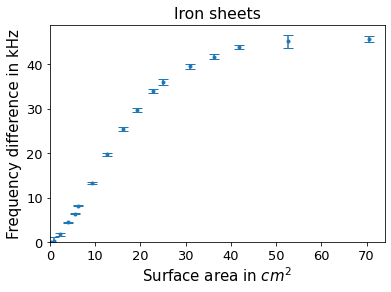

In [19]:
# All data is collected at a distance of 0.65cm

fig, ax1 = plt.subplots()
ax1.errorbar(copper_surface, copper_shape_freq_means, fmt='o', color=freq_color, capsize=3, markersize=3, yerr=copper_shape_freq_stds, label='Frequency difference', zorder=10)
#ax1.plot(iron_surface, iron_shape_freq_diff, 'x', label='Iron')
#ax1.plot(ironthick_surface, ironthick_shape_freq_diff, 'x', label='thick iron')
plt.title("Copper sheets")
plt.xlabel(r"Surface area in $cm^2$", fontsize=15)

ax1.set_ylabel("Frequency difference in kHz", color='black', fontsize=15)

#ax1.legend(loc="lower right", bbox_to_anchor=(1,0.3), fontsize=14)

#ax1.axhline(y=0, color='black')
#ax2.axvline(x=0, color='black')
ax1.set_xlim(0)
ax1.set_ylim(0)

# Iron
fig, ax1 = plt.subplots()
ax1.errorbar(iron_surface, iron_shape_freq_means, fmt='o', color=freq_color, capsize=5, markersize=3, yerr=iron_shape_freq_stds, label='Frequency difference')
plt.title("Iron sheets")
plt.xlabel(r"Surface area in $cm^2$", fontsize=15)
ax1.set_ylabel("Frequency difference in kHz", color='black', fontsize=15)

#l1 = ax1.legend(loc="lower right", bbox_to_anchor=(1,0.6), fontsize=14)
#l2 = ax2.legend(loc="lower right", bbox_to_anchor=(1,0.45), fontsize=14)
#l1.set_zorder(20)
#l2.set_zorder(30)

#ax1.axhline(y=0, color='black')
#ax2.axvline(x=0, color='black')
ax1.set_xlim(0)
ax1.set_ylim(0)
plt.show()

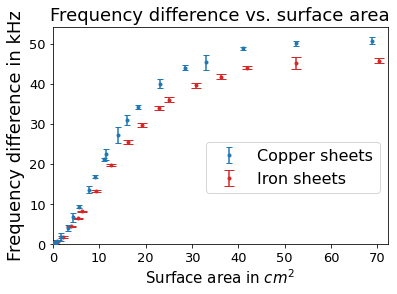

In [20]:
# All data is collected at a distance of 0.65cm

fig, ax1 = plt.subplots()
ax1.errorbar(copper_surface, copper_shape_freq_means, fmt='o', color=freq_color, capsize=3, markersize=3, yerr=copper_shape_freq_stds, label='Copper sheets', zorder=10)
#ax1.plot(iron_surface, iron_shape_freq_diff, 'x', label='Iron')
#ax1.plot(ironthick_surface, ironthick_shape_freq_diff, 'x', label='thick iron')
plt.title("Frequency difference vs. surface area", fontsize=18)
plt.xlabel("Surface area in cm^2", fontsize=18)

#ax1.legend(loc="lower right", bbox_to_anchor=(1,0.3), fontsize=14)

#ax1.axhline(y=0, color='black')
#ax2.axvline(x=0, color='black')
ax1.set_xlim(0)
ax1.set_ylim(0)

# Iron
ax1.errorbar(iron_surface, iron_shape_freq_means, fmt='o', color='tab:red', capsize=5, markersize=3, yerr=iron_shape_freq_stds, label='Iron sheets')
plt.xlabel(r"Surface area in $cm^2$", fontsize=15)
ax1.set_ylabel("Frequency difference in kHz", color='black', fontsize=18)

ax1.legend(loc="lower right", bbox_to_anchor=(1,0.2), fontsize=16)

#ax1.axhline(y=0, color='black')
#ax2.axvline(x=0, color='black')
ax1.set_xlim(0)
ax1.set_ylim(0)
plt.show()

## Plot distance data

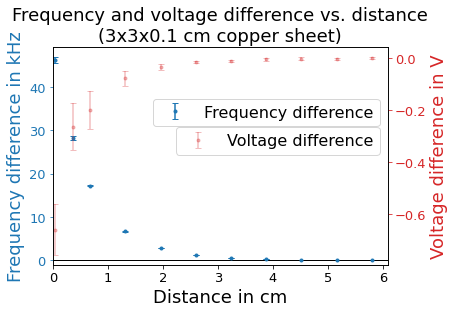

In [21]:
# All data is collected with a 3x3x0.1cm copper sheet

fig, ax1 = plt.subplots()
ax1.errorbar(distances, distance_freq_means, yerr=distance_freq_stds, fmt='o', color=freq_color, capsize=3, markersize=3, label='Frequency difference')
plt.title("Frequency and voltage difference vs. distance\n(3x3x0.1 cm copper sheet)", fontsize=18)
ax1.set_xlabel("Distance in cm", fontsize=18)
ax1.set_ylabel("Frequency difference in kHz", color=freq_color, fontsize=18)

#ax1.axhline(y=0, color='black')
#ax1.axvline(x=0, color='black')

ax2 = ax1.twinx()
ax2.errorbar(distances, distance_volt_means, yerr=distance_volt_stds, fmt='o', color=volt_color, capsize=3, markersize=3, label='Voltage difference', alpha=0.3)
ax2.set_ylabel("Voltage difference in V", color=volt_color, fontsize=18)

ax1.legend(loc="lower right", bbox_to_anchor=(1,0.6), fontsize=16)
ax2.legend(loc="lower right", bbox_to_anchor=(1,0.47), fontsize=16)

ax1.tick_params(axis='y', colors=freq_color)
ax2.tick_params(axis='y', colors=volt_color)
ax1.set_xlim(0)
ax1.set_ylim(-1)
ax1.axhline(y=0, color='black', linewidth=1)
plt.show()

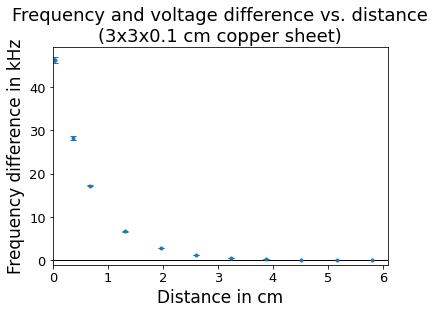

In [22]:
# All data is collected with a 3x3x0.1cm copper sheet

fig, ax1 = plt.subplots()
ax1.errorbar(distances, distance_freq_means, yerr=distance_freq_stds, fmt='o', color=freq_color, capsize=3, markersize=3, label='Frequency difference')
plt.title("Frequency and voltage difference vs. distance\n(3x3x0.1 cm copper sheet)", fontsize=18)
ax1.set_xlabel("Distance in cm", fontsize=17)
ax1.set_ylabel("Frequency difference in kHz", color='black', fontsize=17)


#ax1.legend(loc="lower right", bbox_to_anchor=(1,0.6), fontsize=14)
ax1.set_xlim(0)
ax1.set_ylim(-1)
ax1.axhline(y=0, color='black', linewidth=1)
plt.show()

## Plots for material comparison

Resistivities in Ohm Metres:

* Silver: 1.59 x 10^-8
* Copper: 1.68 x 10^-8
* Gold: 2.44 x 10^-8
* Iron: 9.70 x 10^-8
* Brass: ~6 - 9 x 10^-8

All values were obtained from a distance of 0.65cm.

In [23]:
def autolabel(rects, ax, offset):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, offset),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

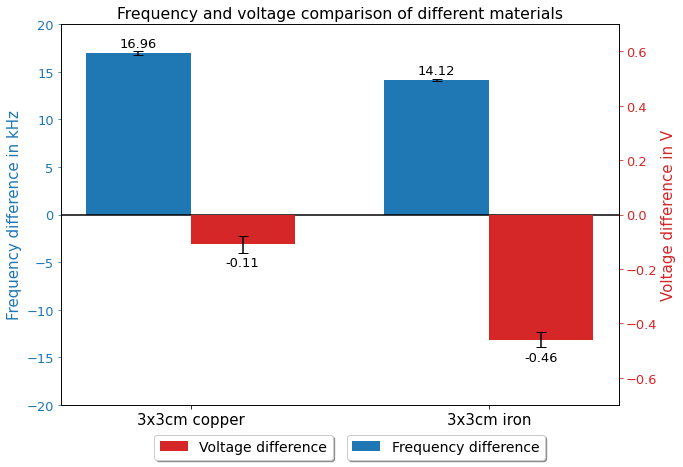

In [24]:
# Put histograms here for copper and iron frequencies and voltages including their resistivities
# single_copper_sheet_freq = material_freq_means[8]
# single_copper_sheet_freq_std = material_freq_stds[8]
# single_iron_sheet_freq = material_freq_means[6]
# single_iron_sheet_freq_std = material_freq_stds[6]

# single_copper_sheet_volt = material_volt_means[8]
# single_copper_sheet_volt_std = material_volt_stds[8]
# single_iron_sheet_volt = material_volt_means[6]
# single_iron_sheet_volt_std = material_volt_stds[6]

# freq_data = np.array([single_copper_sheet_freq, single_iron_sheet_freq], dtype=np.float64).round(2)
# volt_data = np.array([single_copper_sheet_volt, single_iron_sheet_volt], dtype=np.float64).round(2) * -1
# freq_error = np.array([single_copper_sheet_freq_std, single_iron_sheet_freq_std], dtype=np.float64)
# volt_error = np.array([single_copper_sheet_volt_std, single_iron_sheet_volt_std], dtype=np.float64)

single_copper_sheet_freq = material_freq_means[0]
single_copper_sheet_freq_std = material_freq_stds[0]
single_iron_sheet_freq = material_freq_means[1]
single_iron_sheet_freq_std = material_freq_stds[1]

single_copper_sheet_volt = material_volt_means[0]
single_copper_sheet_volt_std = material_volt_stds[0]
single_iron_sheet_volt = material_volt_means[1]
single_iron_sheet_volt_std = material_volt_stds[1]

freq_data = np.array([single_copper_sheet_freq, single_iron_sheet_freq], dtype=np.float64).round(2)
volt_data = np.array([single_copper_sheet_volt, single_iron_sheet_volt], dtype=np.float64).round(2)
freq_error = np.array([single_copper_sheet_freq_std, single_iron_sheet_freq_std], dtype=np.float64)
volt_error = np.array([single_copper_sheet_volt_std, single_iron_sheet_volt_std], dtype=np.float64)

labels = ["3x3cm copper", "3x3cm iron"]

width = 0.35
x = np.arange(len(labels))

fig, ax1 = plt.subplots(figsize=(10,7))
rects1 = ax1.bar(x - width/2, freq_data, width, yerr=freq_error, color=freq_color, capsize=5, label='Frequency difference')
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, volt_data, width, yerr=volt_error, color=volt_color, capsize=5, label='Voltage difference')

plt.title("Frequency and voltage comparison of different materials")
ax1.set_ylabel("Frequency difference in kHz", color=freq_color, fontsize=15)
ax2.set_ylabel("Voltage difference in V", color=volt_color, fontsize=15)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=15)
ax1.legend(loc='upper left', fontsize=14, bbox_to_anchor=(0.5, -0.06), shadow=True, ncol=2)
ax2.legend(loc='upper right', fontsize=14, bbox_to_anchor=(0.5, -0.06), shadow=True, ncol=2)


ax1.tick_params(axis='y', colors=freq_color)
ax2.tick_params(axis='y', colors=volt_color)
ax1.set_ylim(-20.0, 20.0)
ax2.set_ylim(-0.7,0.7)
autolabel(rects1, ax1, 3)
autolabel(rects2, ax2, -25)
ax1.axhline(0, color='black')
#fig.tight_layout()
plt.show()

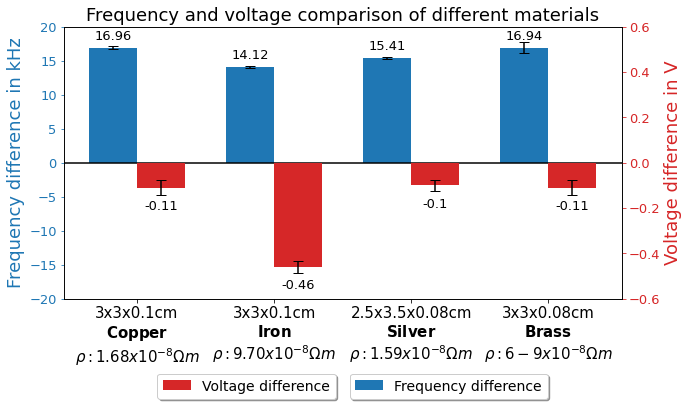

In [25]:
# material comp

width = 0.35
x = np.arange(len(material_labels))

fig, ax1 = plt.subplots(figsize=(10,5))
rects1 = ax1.bar(x - width/2, np.round(material_freq_means,2), width, yerr=material_freq_stds, color=freq_color, capsize=5, label='Frequency difference')
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, np.round(material_volt_means,2), width, yerr=material_volt_stds, color=volt_color, capsize=5, label='Voltage difference')

plt.title("Frequency and voltage comparison of different materials", fontsize=18)
ax1.set_ylabel("Frequency difference in kHz", color=freq_color, fontsize=18)
ax2.set_ylabel("Voltage difference in V", color=volt_color, fontsize=18)
ax1.set_xticks(x)
ax1.set_xticklabels(material_labels, fontsize=15)
ax1.legend(loc='upper left', fontsize=14, bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=2)
ax2.legend(loc='upper right', fontsize=14, bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=2)

ax1.tick_params(axis='y', colors=freq_color)
ax2.tick_params(axis='y', colors=volt_color)

ax1.set_ylim(-20.0, 20.0)
ax2.set_ylim(-0.6,0.6)
ax1.axhline(0, color='black')

autolabel(rects1, ax1, 5)
autolabel(rects2, ax2, -25)
#fig.tight_layout()
plt.show()

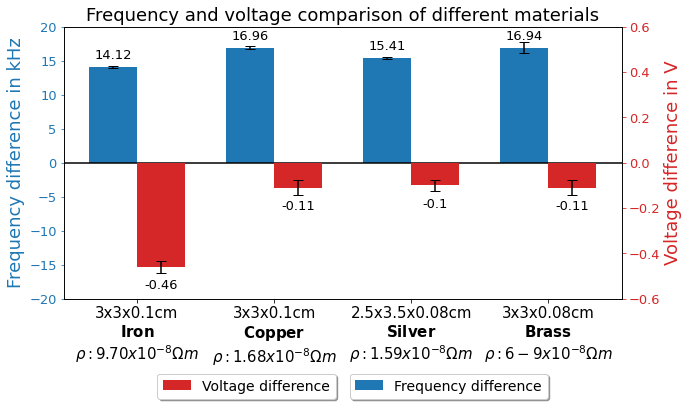

In [26]:
# iron first material comp for better ferromagnetic vs. nonferromagnetic distinction

width = 0.35
x = np.arange(len(material_labels))

ironfirst_labels = ['3x3x0.1cm\n$\\bf{Iron}$\n$\\it{\\rho: 9.70x10^{-8} \Omega m}$',
                    '3x3x0.1cm\n$\\bf{Copper}$\n$\\it\\rho: 1.68x10^{-8} \Omega m}$',
                   '2.5x3.5x0.08cm\n$\\bf{Silver}$\n$\\it{\\rho: 1.59x10^{-8} \Omega m}$',
                   '3x3x0.08cm\n$\\bf{Brass}$\n$\\it{\\rho: 6-9 x10^{-8} \Omega m}$']

ironfirst_freq_means = np.array([material_freq_means[1], material_freq_means[0], material_freq_means[2], material_freq_means[3]])
ironfirst_freq_stds = np.array([material_freq_stds[1], material_freq_stds[0], material_freq_stds[2], material_freq_stds[3]])
ironfirst_volt_means = np.array([material_volt_means[1], material_volt_means[0], material_volt_means[2], material_volt_means[3]])
ironfirst_volt_stds = np.array([material_volt_stds[1], material_volt_stds[0], material_volt_stds[2], material_volt_stds[3]])

fig, ax1 = plt.subplots(figsize=(10,5))
rects1 = ax1.bar(x - width/2, np.round(ironfirst_freq_means,2), width, yerr=ironfirst_freq_stds, color=freq_color, capsize=5, label='Frequency difference')
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, np.round(ironfirst_volt_means,2), width, yerr=ironfirst_volt_stds, color=volt_color, capsize=5, label='Voltage difference')

plt.title("Frequency and voltage comparison of different materials", fontsize=18)
ax1.set_ylabel("Frequency difference in kHz", color=freq_color, fontsize=18)
ax2.set_ylabel("Voltage difference in V", color=volt_color, fontsize=18)
ax1.set_xticks(x)
ax1.set_xticklabels(ironfirst_labels, fontsize=15)
ax1.legend(loc='upper left', fontsize=14, bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=2)
ax2.legend(loc='upper right', fontsize=14, bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=2)

ax1.tick_params(axis='y', colors=freq_color)
ax2.tick_params(axis='y', colors=volt_color)

ax1.set_ylim(-20.0, 20.0)
ax2.set_ylim(-0.6,0.6)
ax1.axhline(0, color='black')

autolabel(rects1, ax1, 5)
autolabel(rects2, ax2, -25)
#fig.tight_layout()
plt.show()

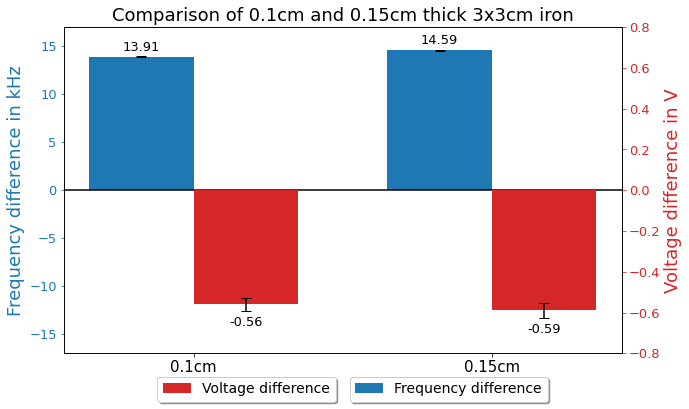

In [27]:
# ironthick comp

width = 0.35
x = np.arange(len(ironthickcomp_labels))

fig, ax1 = plt.subplots(figsize=(10,6))
rects1 = ax1.bar(x - width/2, np.round(ironthickcomp_freq_means,2), width, yerr=ironthickcomp_freq_stds, color=freq_color, capsize=5, label='Frequency difference')
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, np.round(ironthickcomp_volt_means,2), width, yerr=ironthickcomp_volt_stds, color=volt_color, capsize=5, label='Voltage difference')

plt.title("Comparison of 0.1cm and 0.15cm thick 3x3cm iron", fontsize=18)
ax1.set_ylabel("Frequency difference in kHz", color=freq_color, fontsize=18)
ax2.set_ylabel("Voltage difference in V", color=volt_color, fontsize=18)
ax1.set_xticks(x)
ax1.set_xticklabels(ironthickcomp_labels, fontsize=15)
ax1.legend(loc='upper left', fontsize=14, bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
ax2.legend(loc='upper right', fontsize=14, bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

ax1.tick_params(axis='y', colors=freq_color)
ax2.tick_params(axis='y', colors=volt_color)

ax1.set_ylim(-17.0, 17.0)
ax2.set_ylim(-0.8,0.8)
ax1.axhline(0, color='black')

autolabel(rects1, ax1, 3)
autolabel(rects2, ax2, -25)
#fig.tight_layout()
plt.show()

## Logarithmic Plots

In [28]:
# fit functions

# 1/sqrt(x)
def root_fit(x, k):
    return 1/(k*np.sqrt(x))

# 1/x
def linear_fit(x, k):
    return 1/(k*x)

# 1/x^2
def square_fit(x, k, off):
    return 1/(k*x**2) + off

def exp_fit(x, k, exp):
    return k* np.e**(exp*x)

def rlc_fit(x, a, b):
    return (np.sqrt(1/(a*x**2) + 1/(b*x**2)))/(2*np.pi)

In [29]:
root_popt, pcov = curve_fit(root_fit, distances, distance_freq_means)

linear_popt, pcov = curve_fit(linear_fit, distances, distance_freq_means)

square_popt, pcov = curve_fit(square_fit, distances, distance_freq_means)

exp_popt, pcov = curve_fit(exp_fit, distances, distance_freq_means)

rlc_popt, pcov = curve_fit(rlc_fit, distances, distance_freq_means)

<ipython-input-28-30c0759eb10b>:19: RuntimeWarning: invalid value encountered in sqrt
  return (np.sqrt(1/(a*x**2) + 1/(b*x**2)))/(2*np.pi)


[46.21005322 28.24729269 17.28872493  6.68747163  2.86235234  1.3013179
  0.63673353  0.33254309  0.18667639  0.103941    0.06286528]
-1.2349151258062079


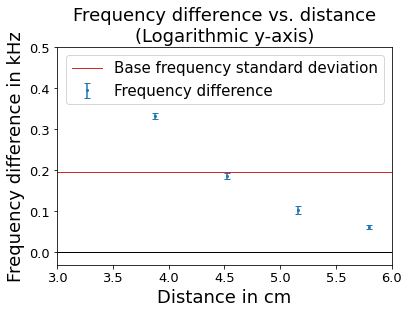

In [30]:
# Find correct proportionality to distance by determining the slope of the logarithmic plot
# For the slope determination a linear regression will be used
print(distance_freq_means)
fig, ax1 = plt.subplots()
ax1.errorbar(distances, distance_freq_means, fmt='o', color=freq_color, yerr=distance_freq_stds, capsize=3, markersize=2, label='Frequency difference')
#ax1.plot(distances[:9], np.log(distance_freq_diff[:9]), 'x', label='Frequency difference')
plt.title("Frequency difference vs. distance\n(Logarithmic y-axis)", fontsize=18)
ax1.set_xlabel("Distance in cm", fontsize=18)
ax1.set_ylabel("Frequency difference in kHz", color='black', fontsize=18)
#ax1.set_yscale('log')
#ax1.set_xscale('log')
#plt.xscale('log')
#plt.ylim(10**-2)

fitx = np.arange(0.04,7,0.01)
#ax1.plot(fitx, root_fit(fitx, *root_popt), color='tab:purple', label=r'Fit: $\frac{1}{k \cdot \sqrt{r}}$')
#ax1.plot(fitx, linear_fit(fitx, *linear_popt), color='tab:orange', label=r"Fit: $\frac{1}{k \cdot r}$")
#ax1.plot(fitx, square_fit(fitx, *square_popt), label='1/(k * x**2) + offset')
#ax1.plot(fitx, exp_fit(fitx, *exp_popt), color='tab:green', label=r'Fit: $k \cdot e^{\lambda r}$')
#ax1.plot(fitx, rlc_fit(fitx, *rlc_popt), color='yellow', label='rlc')


#ax2 = ax1.twinx()
#ax2.plot(distances, -2*distances+30)

#plt.ylim(-1,50)
#plt.yscale('log')

slope, intercept, r, p, se = linregress(distances.reshape((-1,))[:9], np.log(distance_freq_diff.reshape((-1,))[:9]))
print(slope)
#ax1.plot(distances, slope*distances + intercept)

#ax1 = ax1.twinx()
#ax1.plot(distances, slope * distances + intercept, '-x')
#ax1.axhline(y=0)
#ax1.axvline(x=0)
#ax1.legend(loc="lower right", bbox_to_anchor=(1,0.6))

# ax1.tick_params(axis='y', colors=freq_color)
# ax2.tick_params(axis='y', colors=volt_color)

ax1.set_ylim(-0.03,0.5)
ax1.set_xlim(3,6)
ax1.axhline(0, color='black', linewidth=1)

ax1.axhline(empty_std, color='tab:red', linewidth=1, label='Base frequency standard deviation')

ax1.legend(loc="best", fontsize=15)

plt.show()

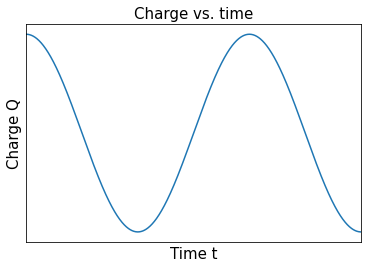

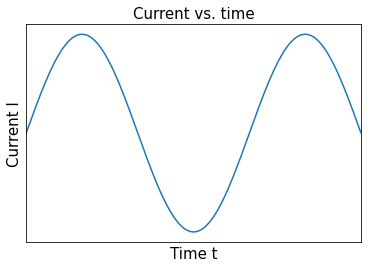

In [47]:
# basic cosine and sine plots
x = np.arange(0, np.pi*3, 0.01)
cos = np.cos(x)
sin = np.sin(x)

plt.figure(1)
plt.title("Charge vs. time", fontsize=15)
plt.xlabel("Time t", fontsize=15)
plt.ylabel("Charge Q", fontsize=15)
plt.xlim(0,np.pi*3)
#plt.axhline(0, color='black')
plt.xticks([])
plt.yticks([])
plt.plot(x, cos)

plt.figure(2)
plt.title("Current vs. time", fontsize=15)
plt.xlabel("Time t", fontsize=15)
plt.ylabel("Current I", fontsize=15)
plt.xlim(0,np.pi*3)
#plt.axhline(0, color='black')
plt.xticks([])
plt.yticks([])
plt.plot(x, sin)